In [1]:
import numpy as np
import matplotlib.pyplot as plt
from few.waveform import GenerateEMRIWaveform, FastSchwarzschildEccentricFlux, FastKerrEccentricEquatorialFlux
from few.utils.constants import Gpc, MRSUN_SI, YRSID_SI
from typing import Optional, Union, Callable
from tqdm import tqdm

#try:
#    import cupy as cp
#    use_gpu = True
#except ImportError():
#    print("Not on GPU")
#    use_gpu = False

use_gpu = False

from stableemrifisher.fisher.fisher import StableEMRIFisher
from stableemrifisher.utils import inner_product

from fastlisaresponse import ResponseWrapper  # Response function 
from lisatools.detector import ESAOrbits #ESAOrbits correspond to esa-trailing-orbits.h5
from lisatools.sensitivity import get_sensitivity, A1TDISens, E1TDISens, T1TDISens

if not use_gpu:
    
    import few
    
    #tune few configuration
    cfg_set = few.get_config_setter(reset=True)
    
    cfg_set.enable_backends("cpu")
    cfg_set.set_log_level("info");
    force_backend = 'cpu'
else:
    force_backend = 'gpu'
    pass #let the backend decide for itself.

startup


In [2]:
#waveform class setup
waveform_class = FastSchwarzschildEccentricFlux
waveform_class_kwargs = dict(inspiral_kwargs=dict(err=1e-11,),
                             mode_selector_kwargs=dict(mode_selection_threshold=1e-5))

#waveform generator setup
waveform_generator = GenerateEMRIWaveform
waveform_generator_kwargs = dict(return_list=False)

#ResponseWrapper setup
ResponseWrapper = ResponseWrapper
tdi_gen ="1st generation"# "2nd generation"#
order = 20  # interpolation order (should not change the result too much)
tdi_kwargs_esa = dict(
    orbits=ESAOrbits(use_gpu=use_gpu), order=order, tdi=tdi_gen, tdi_chan="AE",
)  # could do "AET"
index_lambda = 8
index_beta = 7
# with longer signals we care less about this
t0 = 10000.0  # throw away on both ends when our orbital information is weird
T = 0.1
dt = 10.0

ResponseWrapper_kwargs = dict(
    #waveform_gen=waveform_generator,
    Tobs = T,
    dt = dt,
    index_lambda = index_lambda,
    index_beta = index_beta,
    t0 = t0,
    flip_hx = True,
    use_gpu=use_gpu,
    is_ecliptic_latitude=False,
    remove_garbage="zero",
    **tdi_kwargs_esa
)

#noise setup
channels = [A1TDISens, E1TDISens]
noise_model = get_sensitivity
noise_kwargs = [{"sens_fn": channel_i} for channel_i in channels]

In [3]:
sef = StableEMRIFisher(waveform_class=waveform_class, 
                       waveform_class_kwargs=waveform_class_kwargs,
                       waveform_generator=waveform_generator,
                       waveform_generator_kwargs=waveform_generator_kwargs,
                       ResponseWrapper=ResponseWrapper, ResponseWrapper_kwargs=ResponseWrapper_kwargs,
                       noise_model=noise_model, noise_kwargs=noise_kwargs, channels=channels,
                      stats_for_nerds = True, use_gpu = use_gpu,
                      deriv_type='stable')

In [4]:
m1 = 1e6
m2 = 1e1
a = 0.
p0 = 9.5
e0 = 0.4
xI0 = 1.0
dist = 0.1
qS = np.pi/3
phiS = np.pi/4
qK = np.pi/6
phiK = np.pi/8
Phi_phi0 = 1.0
Phi_theta0 = 0.0
Phi_r0 = 0.0

pars_list = [m1, m2, a, p0, e0, xI0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
param_names = ['m1','m2','p0','e0','dist','qS','phiS','qK','phiK','Phi_phi0','Phi_r0']

emri_kwargs = {"T":T, "dt":dt}

sef.SNRcalc_SEF(*pars_list,**emri_kwargs)

wave ndim: 2
Computing SNR for parameters: (1000000.0, 10.0, 0.0, 9.5, 0.4, 1.0, 0.1, 1.0471975511965976, 0.7853981633974483, 0.5235987755982988, 0.39269908169872414, 1.0, 0.0, 0.0)


np.float64(119.32881779777361)

In [5]:
m1 = 1e6
m2 = 1e1
a = 0.
p0 = 9.5
e0 = 0.4
xI0 = 1.0
dist = 0.1
qS = np.pi/3
phiS = np.pi/4
qK = np.pi/6
phiK = np.pi/8
Phi_phi0 = 1.0
Phi_theta0 = 0.0
Phi_r0 = 0.0

pars_list = [m1, m2, a, p0, e0, xI0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
param_names = ['m1','m2','p0','e0','dist','qS','phiS','qK','phiK','Phi_phi0','Phi_r0']

der_order = 4
Ndelta = 8
stability_plot = True

delta_range = dict(
    m1 = np.geomspace(1e-4*m1, 1e-9*m1, Ndelta),
    m2 = np.geomspace(1e-2*m2, 1e-7*m2, Ndelta),
    p0 = np.geomspace(1e-2*p0, 1e-7*p0, Ndelta),
    e0 = np.geomspace(1e-1*e0, 1e-7*e0, Ndelta),
    qS = np.geomspace(1e-4,    1e-9,    Ndelta),
    phiS = np.geomspace(1e-4,    1e-9,    Ndelta),
    qK = np.geomspace(1e-4,    1e-9,    Ndelta),
    phiK = np.geomspace(1e-4,    1e-9,    Ndelta),
)

Fisher = sef(*pars_list, param_names = param_names, 
             T = T, dt = dt, 
             der_order = der_order, 
             Ndelta = Ndelta, 
             stability_plot = stability_plot,
             delta_range = delta_range,
            live_dangerously = False)

T:  0.1 dt:  10.0
Body is not plunging, Fisher should be stable.
wave ndim: 2
Computing SNR for parameters: (1000000.0, 10.0, 0.0, 9.5, 0.4, 1.0, 0.1, 1.0471975511965976, 0.7853981633974483, 0.5235987755982988, 0.39269908169872414, 1.0, 0.0, 0.0)
Waveform Generated. SNR: 119.32881779777361
calculating stable deltas...
Gamma_ii for m1: 28.11492907176752
Gamma_ii for m1: 28.114929071633437
Gamma_ii for m1: 28.11492907231194
Gamma_ii for m1: 28.11492907009086


/home/shubham/miniconda3/envs/few2_april/lib/python3.12/site-packages/fastlisaresponse-1.0.11-py3.12-linux-x86_64.egg/fastlisaresponse/response.py:631: SyntaxWarning: invalid escape sequence '\p'
  """Wrapper to produce LISA TDI from TD waveforms


KeyboardInterrupt: 

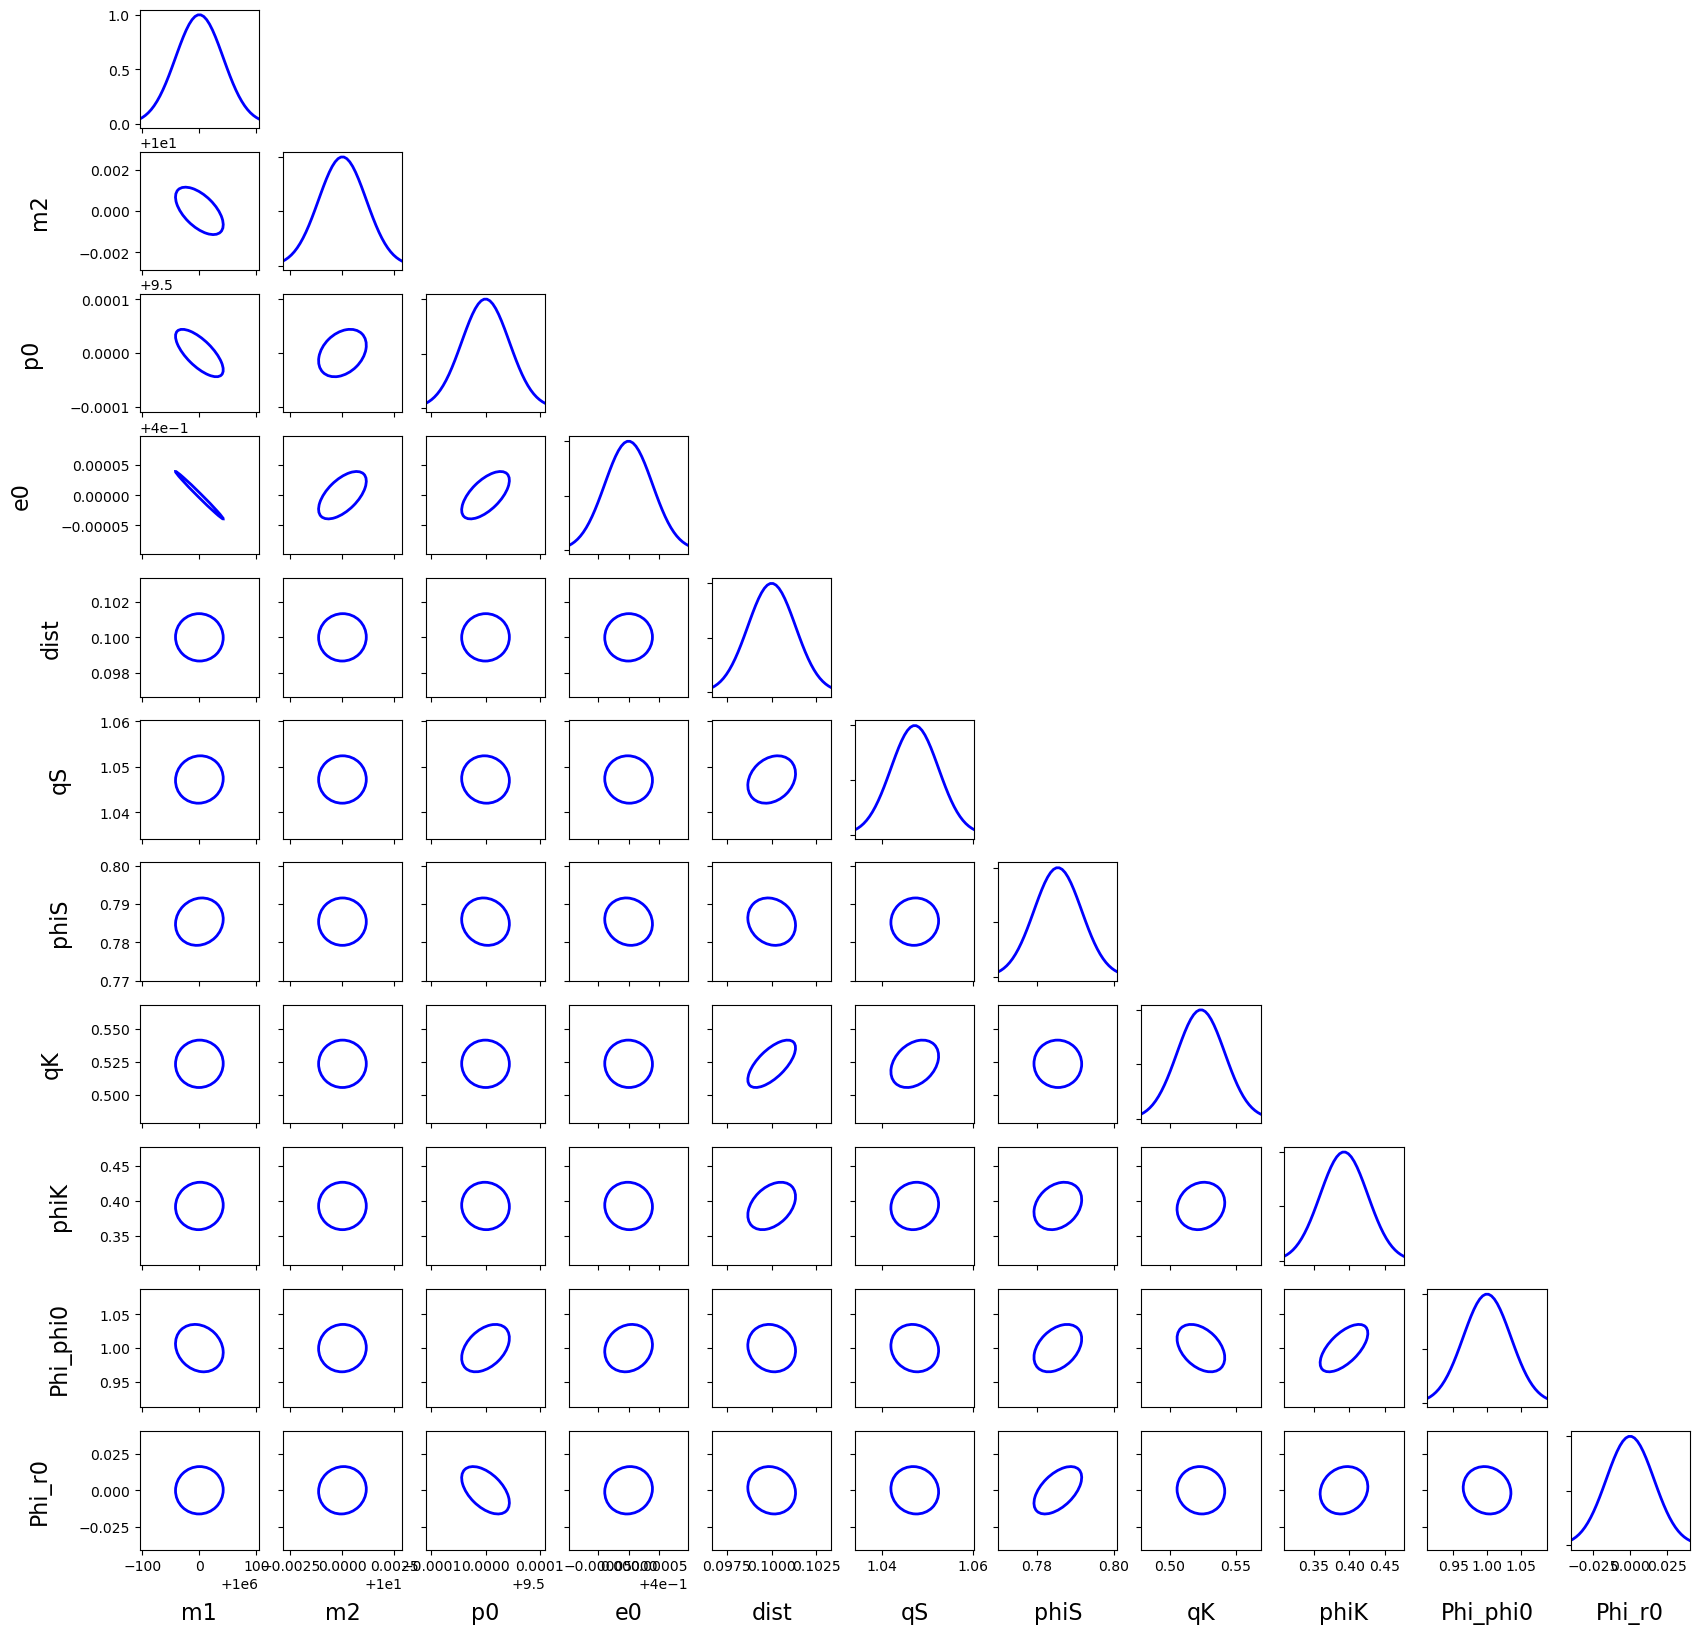

In [5]:
from stableemrifisher.plot import CovEllipsePlot

pars_list = [m1, m2, a, p0, e0, xI0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
pars_name = ['m1','m2','a','p0','e0','xI0','dist','qS','phiS','qK','phiK','Phi_phi0','Phi_theta0','Phi_r0']

wave_params = {}
for i in range(len(pars_list)):
    wave_params[pars_name[i]] = pars_list[i]
    
param_names = param_names

covariance = np.linalg.inv(Fisher)

ellipse_kwargs = dict(facecolor='None', edgecolor='b', lw=2)
line_kwargs = dict(lw=2, color='b')

fig, axs = plt.subplots(len(covariance),len(covariance), figsize=(20,20))
fig, axs = CovEllipsePlot(covariance, wave_params=wave_params, param_names=param_names, fig=fig, axs=axs, ellipse_kwargs=ellipse_kwargs, line_kwargs=line_kwargs)